# Clustering *League of Legends* Player Decisions by Game State
By: Ryan Coops

GitHub: https://github.com/greenbird76/DSCI235_Final_Project

*League of Legends* is a online game divided into various matches in which teams of players compete against each other to destroy the others bases. The central gameplay loop revolves around completing various objectives in order to acquire gold which players exchange for items that make themselves more powerful. The items purchased by players represent one of the major choices available, as different items grant different powers to players. The purpose of this analysis is to analyze the choices made by those players to see if people actually care enough to vary their purchases relative to the game state, as decided by kill/death ratio as a proxy variable for individual success. Clustering will be done via K-means, and the primary question of this analysis will be identifying if the clusters of item choices correspond to game-states. 

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as met
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

First, we will import our csv from the first notebook, Data_Collection.ipynb. This step has been separated out to remedy the issues with reading Kaggle data from cache, as that's an absolute path. The data includes the champion (the player's character), their role on the team, gameID data, and victory status. After that includes the seven item choices, signified by their four digit item IDs, and one-hot encodings for all the item choices.

In [197]:
items = pd.read_csv("data/encodedLeagueData.csv")
pd.DataFrame.head(items)

,championName,lane,GameID,win,item0,item1,item2,item3,item4,item5,...,7014,7015,7016,7017,7018,7019,7020,7021,7022,8001
0,Trundle,JUNGLE,4035079604,True,3075,2031,3044,3047,6632,1037,...,0,0,0,0,0,0,0,0,0,0
1,Sylas,MIDDLE,4035079604,True,4629,3157,6656,3020,1082,1058,...,0,0,0,0,0,0,0,0,0,0
2,Viego,JUNGLE,4035079604,False,3047,2031,6632,3153,1031,0,...,0,0,0,0,0,0,0,0,0,0
3,Yasuo,MIDDLE,4035079604,False,6333,3006,6673,3031,3072,0,...,0,0,0,0,0,0,0,0,0,0
4,Caitlyn,BOTTOM,4035079604,False,1055,6672,3006,3031,0,0,...,0,0,0,0,0,0,0,0,0,0


## Method Selection
The obvious problem with this data is its dimensionality is much higher than its size, which could make clustering difficult. Thankfully, most of those dimensions are probably zero for most champions, since there are a lot of bad choices. We will check that now for an example case for the most popular champion/role combination.

In [198]:
items.groupby(['championName','lane']).count()['GameID'].idxmax()

('Ashe', 'BOTTOM')

In [199]:
ashe = (items[(items['championName']=='Ashe')&(items['lane']=='BOTTOM')].
        drop(columns=['championName','lane','GameID','win','item0','item1','item2','item3','item4','item5','item6','kills','assists','deaths']).
        copy())
(ashe.sum()>0).sum()

np.int64(109)

As we can see, on the most popular champion in her most popular role, only 107 of the items were purchased (KDA column was upheld). This may still be too many dimensions, but we're not going to worry about that right now. Onto clustering, we will be using scikit learns KMeans and varying the only hyperparameter, cluster number, on our Ashe data. Due to the lack of 'true' classifications (ground truth labels), clustering efficacy will have to be measured by either Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Boudin Index. Thankfully, all of these have methods in scikit-learn, which is  

In [200]:
def measurement_testing(X, count, PCAV=False,start=20,step=5):
    accuracies = np.zeros([count,4])
    if PCAV == False:
        clusters = np.arange(count)+2
        for i in clusters:
            kmeans = KMeans(n_clusters=i,random_state=108+i,n_init="auto").fit(X)
            labels=kmeans.labels_
            accuracies[i-2,0]=i
            accuracies[i-2,1]=met.silhouette_score(X, labels, metric='euclidean')
            accuracies[i-2,2]=met.calinski_harabasz_score(X, labels)
            accuracies[i-2,3]=met.davies_bouldin_score(X, labels)
        return accuracies
    else:
        PCAtypes = np.arange(start,step*count+start,step)
        lp = 0
        for i in PCAtypes:
            pca = PCA(n_components=i).fit(X)
            PCAtest = pca.transform(X)
            kmeans = KMeans(n_clusters=4,random_state=108+i,n_init="auto").fit(PCAtest)
            labels=kmeans.labels_
            accuracies[lp,0]=i
            accuracies[lp,1]=met.silhouette_score(PCAtest, labels, metric='euclidean')
            accuracies[lp,2]=met.calinski_harabasz_score(PCAtest, labels)
            accuracies[lp,3]=met.davies_bouldin_score(PCAtest, labels)
            lp=lp+1
        return accuracies

In [201]:
Xashe= np.array(ashe.drop(columns='KDA'))
acc1 = measurement_testing(Xashe, 19)
acc1[:,1].max(),acc1[:,2].max(),acc1[:,3].max()

(np.float64(0.1395039393950518),
 np.float64(193.60266445062305),
 np.float64(3.0625498020592374))

Well, now we have our maximum accuracies. At a glance, these scores don't look super promising. "Good" Silhouette scores are as close to 1 as possible, with a minimum of -1. Calinski-Harabasz indices should just be as high as possible, with no ideal scores. Davies-Bouldin scores should be as close to zero as possible, with no set minimum score. This might not be true for every champion. Now we need to see if the scores line up anywhere and investigate the dynamic range of each scoring method. 

In [202]:
def display_scores(accuracies):
    fig1, axs = plt.subplots(3,1,figsize=(10,6))
    axs[0].plot(accuracies[:,0], accuracies[:,1])
    axs[0].set_title('Silhouette Score')
    axs[0].set_ylim([-1,1])

    axs[1].plot(accuracies[:,0], accuracies[:,2])
    axs[1].set_title('Calinski-Harabasz Index')
    axs[1].set_ylim([0,250])

    axs[2].plot(accuracies[:,0], accuracies[:,3])
    axs[2].set_title('Davies-Bouldin Index')

    plt.subplots_adjust(hspace=.5);
    pass

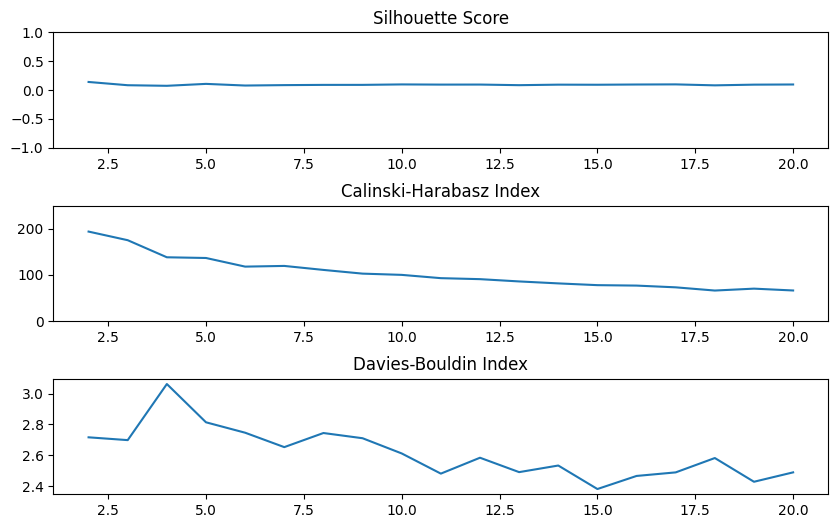

In [203]:
display_scores(acc1)

Well, our original runtime was 2.5 seconds, somewhat increased by measuring accuracy three times. Despite my for-loop architecture, this may yet be viable for the whole data set. The accuracy is fairly invariate for the Silhouette and Davies-Bouldin Indices, though less so for the latter test. The distinction probably suggests that there's probably very few data clusters for this particular champion. Calinski-Harabasz is moderately promising, but I've kind of just shopped around for what worked. The drawbacks of the method tend to be over-representing the efficacy of fitting convex clusters, which Kmeans tends to create. This would be a problem if I were comparing KMeans to other methods, but I'm not, so this is probably fine. That being said, since I'm not happy with this, I'm going to continue shopping around for methods to improve these scores. The first of which will be PCA, which really ought to not do anything, but might improve the runtime.

In [204]:
acc2 = measurement_testing(X=Xashe, count=19, PCAV=True)
acc2[:,1].max(),acc2[:,2].max(),acc2[:,3].max()

(np.float64(0.16225566487431006),
 np.float64(219.85216126911973),
 np.float64(2.7450697976556113))

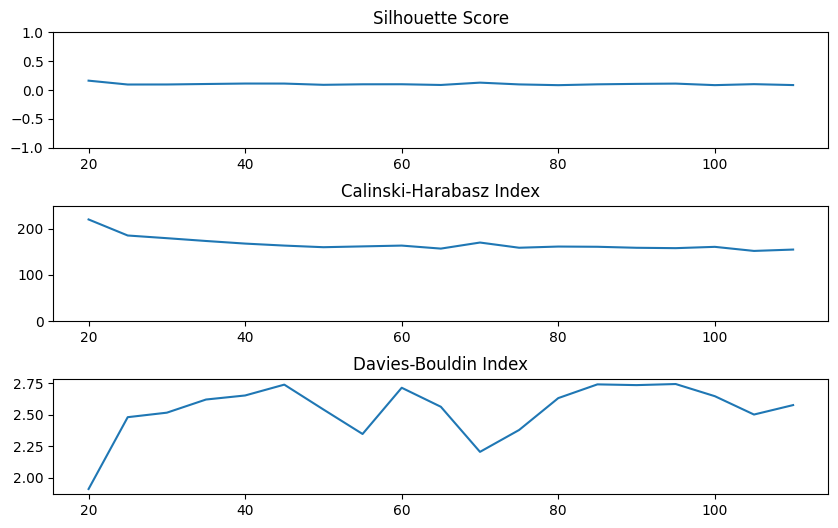

In [205]:
display_scores(acc2)

Well, it looks like fewer components is better, which makes sense since most champions shouldn't be building every item. With that information in hand, we'll see how it affects clustering. (this should ideally be different for each champion, but that'll take forever)

In [206]:
pca = PCA(20).fit(Xashe)
XashePCA = pca.transform(Xashe)
acc3=measurement_testing(XashePCA,19)

That didn't meaningfully change the run time.

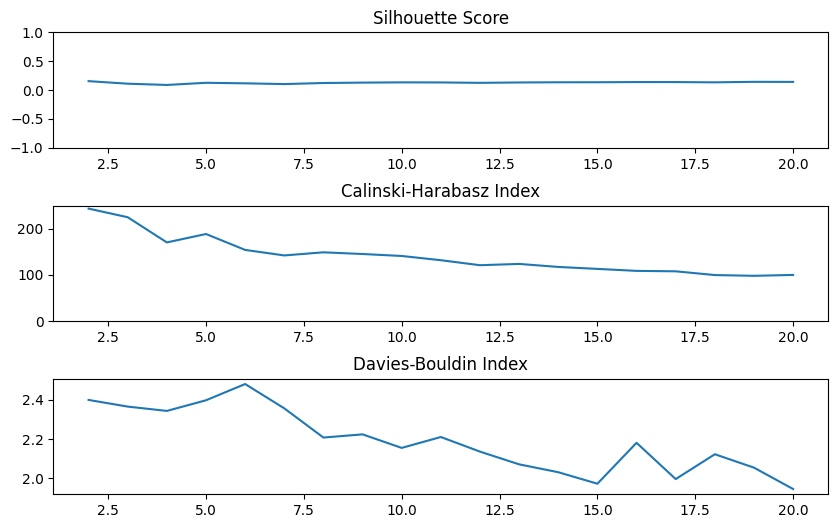

In [207]:
display_scores(acc3)

Now it seems like Davies-Bouldin doesn't really care about cluster count, which seems odd. But it's slightly increase the dynamic range of the Calinski-Harabasz Index, so I guess I'm okay with that. I'm not actually sure PCA makes sense on this data set, since the one-hot encoding means that the angles between dimensions is always 90 degrees, which makes principal components less interesting. What this must do is basically drop items that aren't in the top 20. To that effect, there are certain super common items which everyone buys. Deviations from that pattern would make for interesting clustering, but that deviation might not happen. So I'm gonna drop them and see what happens. 

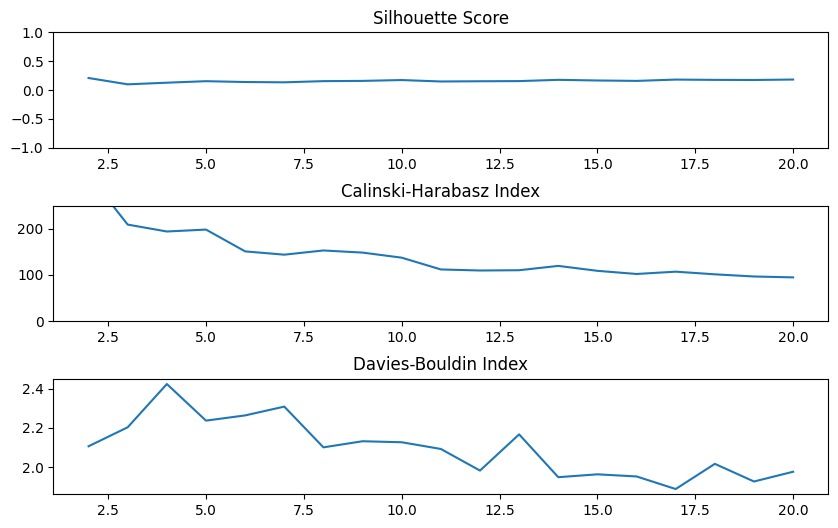

In [208]:
XasheRare = np.array(ashe.drop(columns=['0','1054','1055','1056','3006','3009','3020','3047','3111','1038','1042','1036','1043','1053','3340','3364','3363','KDA']).copy())
accRare = measurement_testing(XasheRare,19)
display_scores(accRare)

There remains little variation amongst the Davies-Bouldin Index though it does seem to be consistently trending down. This is somewhat to be expected since the method compares the similarity between a cluster and its nearest neighbor, and more clusters will generally make that go down for this type of data set, since our data is a bunch of binary data with a maximum of six choices, clusters will increasingly become homogenous, which will eventually push their similarity apart.

 Going forward, I'm going to only run Calinski-Harabasz as our evaluator and drop all of the items which are incomplete or ubiquitous, as this seems to be the most effective set of circumstances. I will not be running PCA, as I don't seem to see many performance improvements from it and I suspect I'd need to optimize it per champion which would just be costly temporally.

## Finding Clusters for Every Champion
Moving on from just Ashe, the point of this inquiry is to see if *League* players adapt their item choices to the game state. This will require identifying the optimal number of clusters for each champion/role combination and then seeing if those clusters have any meaningful difference in mean KDA. To do this, I will use a nested for-loop, since that's what we did in CS345 and I can't think of a vectorized approach. Since this will have serious run-time repercussions, I've decided to divide the processing up by role. This will also allow in-role comparisons, which are independently valuable.

In [209]:
def find_champ_optimal_clusters(X,count=19,rs=58): 
    scores = np.zeros([count,2])
    clusters = np.arange(count)+2
    for i in clusters:
        kmeans = KMeans(n_clusters=i,random_state=rs+i,n_init="auto").fit(X)
        labels=kmeans.labels_
        scores[i-2,0]=i
        scores[i-2,1]=met.calinski_harabasz_score(X, labels)
    return scores[np.argmax(scores[:,1])]

In [210]:
def find_role_optums(X):
    champs = X['championName'].unique()
    best = pd.DataFrame(champs, columns=['Champion'])
    best['Best_Cluster']=0
    best['Best_Accuracy']=0
    best.set_index('Champion',inplace=True)
    for i in champs:
        score = find_champ_optimal_clusters(X[X['championName']==i].drop(columns=['championName','KDA']))
        best.loc[i,'Best_Accuracy']=score[1]  
        best.loc[i,'Best_Cluster']=score[0]  
    return best

In [211]:
def display_spread(cluster_data):
    fig1, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].hist(cluster_data['Best_Cluster'])
    axs[0].set_title('Most Common Clusters')
    #axs[0].set_xlim([2,4])
    axs[0].set_xticks([2,3,4])

    axs[1].scatter(cluster_data['Best_Cluster'], cluster_data['Best_Accuracy'])
    axs[1].set_title('Clusters by Accuracy')
    #axs[1].set_xlim([1.5,4.5])
    axs[1].set_xticks([2,3,4]);
    pass

In addition to the two clustering methods and the display method, we'll also need to instantiate a drop list, which will save us time in the long-run. There's no real pattern to the incomplete items, so I can't do this in data collection. So here's a manual list.

In [212]:
droplist = ['lane','GameID','win','item0','item1','item2','item3','item4','item5','item6','kills','assists','deaths','0','1054','1055','1056','3006','3009','3020','3047','3111','1038','1042','1036','1043','1053','3340','3364','3363','1004','1006','1011','1018','1026','1027','1029','1031','1033','1057','1058','1082','1083','2003','2010','2015','2031','3067','3057','3105','3024','3044','3070','3076','3077','3082','3086','3108','3113','3114','3123','3134','3140','3155','3158','3211','3801','3802','3916','4630','4632','6029','6670','6677']

In [213]:
#If this doesn't throw an error, the droplist works
items.drop(columns=droplist);

First role on the list: Top. Top lane is a one-versus-one lane, which should have relatively many builds due to the efficacy of picking items that specifically undermine your opponent's damage type. 

/tmp/ipykernel_13355/3622500699.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '77.4146218661043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  best.loc[i,'Best_Accuracy']=score[1]


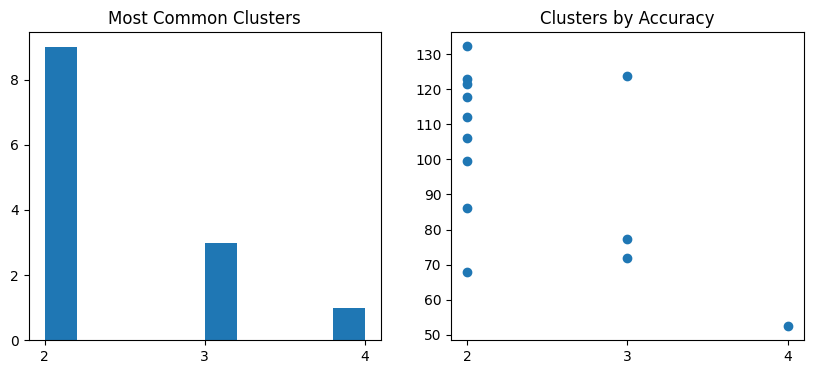

In [214]:
top_best = find_role_optums(items[items['lane']=='TOP'].drop(columns=droplist))
top_best['Lane']='TOP'
display_spread(top_best)

Our accuracies don't look particularly good, though it is coming up with different number of optimal clusters for different champions, though this does seem to be mostly for our lowest accuracy clusterings. Only a single point is at 4, so I suspect we're going to have to keep going. I'm going to omit the graphs for mid and jungle, since they're pretty much the same as top.

In [215]:
mid_best = find_role_optums(items[items['lane']=='MIDDLE'].drop(columns=droplist))
mid_best['Lane']="MIDDLE"
jng_best = find_role_optums(items[items['lane']=='JUNGLE'].drop(columns=droplist))
jng_best['Lane']='JUNGLE'

/tmp/ipykernel_13355/3622500699.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '74.21876601322079' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  best.loc[i,'Best_Accuracy']=score[1]
/tmp/ipykernel_13355/3622500699.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90.2675676336106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  best.loc[i,'Best_Accuracy']=score[1]


Hopefully more interesting is bottom lane, which is a 2v2 lane which contains item systems that are highly synergistic that tend to need to be bought together. There are also relatively few of one of the two roles here, which should push up popularity.

/tmp/ipykernel_13355/3622500699.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '311.6385771134017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  best.loc[i,'Best_Accuracy']=score[1]


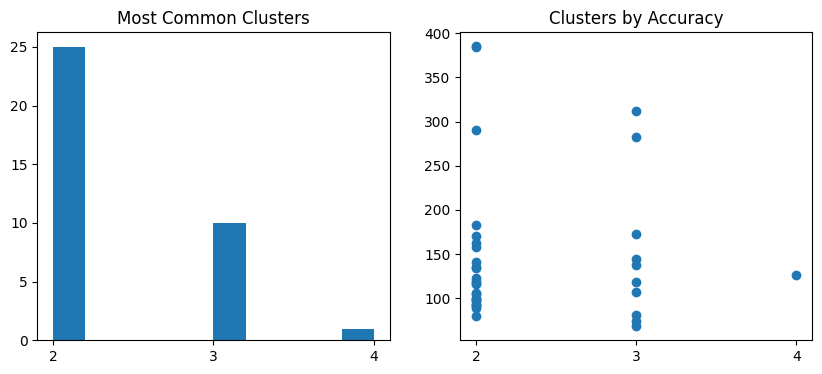

In [216]:
bot_best = find_role_optums(items[items['lane']=='BOTTOM'].drop(columns=droplist))
bot_best['Lane']='BOTTOM'
display_spread(bot_best)

Well, this is the same pattern as we've seen before. More clusters are reserved for worse accuracy, which isn't promising. One thing to note here is that accuracy seems to be higher across the board, likely due to the high popularity of champions in this lane. This suggests that this analysis might be more effective if I had a larger data set.

Next, I'm going to produce one last set of graphs, for the whole data set.

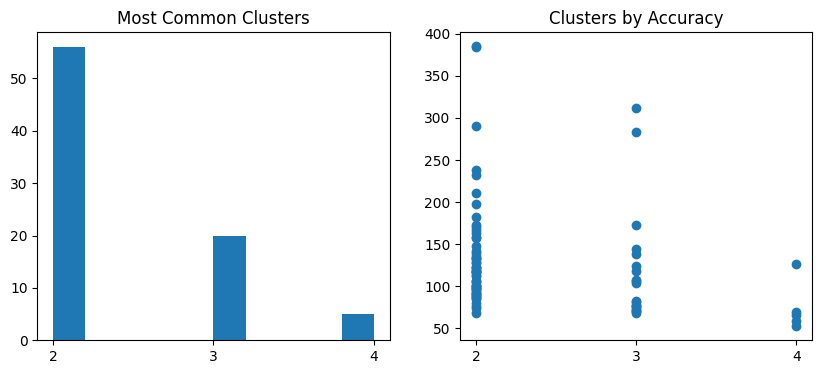

In [217]:
total_best = pd.concat([top_best.reset_index(),jng_best.reset_index()])
total_best = pd.concat([total_best,mid_best.reset_index()])
total_best = pd.concat([total_best,bot_best.reset_index()])
display_spread(total_best)

So this really suggests that this approach to clustering doesn't work super well, since it really seems like the data hugs the minimum number of clusters. That kind of makes sense, since it's easier to build the same thing every game, but it's not a very interesting conclusion. Maybe I'd be able to see more with a greater sample size.

## Clusters by KDA
So clustering didn't work super well, but I'm still interested to see if the clusters we did find have a lot of differences in KDA per cluster, since my original research question was to see if people varied their builds in response to how well they were doing. I'm planning on looking at standard deviation, since that should allow comparison across the different numbers of clusters.

In [247]:
total_best

,Champion,Best_Cluster,Best_Accuracy,Lane
0,TahmKench,3,77.414622,TOP
1,Darius,4,52.412501,TOP
2,Nasus,2,122.943316,TOP
3,Kayle,2,99.690740,TOP
4,Garen,2,112.145232,TOP
...,...,...,...,...
31,Seraphine,2,98.438793,BOTTOM
32,Ziggs,3,68.377741,BOTTOM
33,Sivir,2,105.039763,BOTTOM
34,Xerath,2,91.585875,BOTTOM


In [277]:
devs = np.zeros(total_best.shape[0])
n=0
for i in total_best['Champion']:
    cClus = np.array(total_best[total_best["Champion"]==i]["Best_Cluster"])[0]

    functional = items[items["championName"]==i].drop(columns=droplist).drop(columns=['championName'])

    kmeans = KMeans(n_clusters=cClus,random_state=493,n_init="auto").fit(functional.drop(columns=['KDA']))
    functional['labels']=kmeans.labels_
    devs[n]= np.std(functional.groupby('labels')['KDA'].mean())
    n=n+1
total_best['StDev']=devs

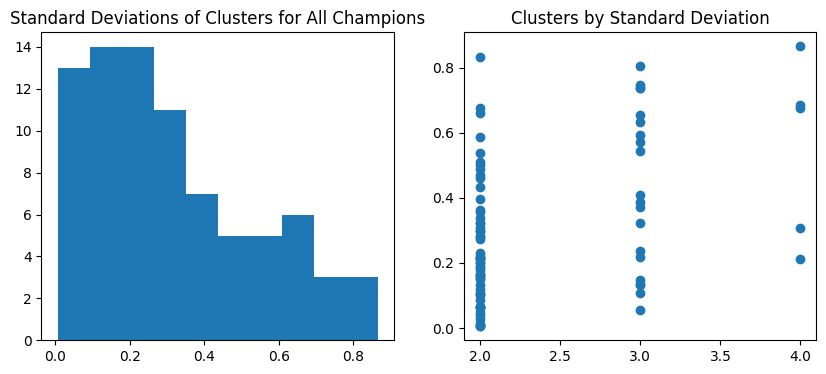

In [281]:
fig1, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].hist(total_best['StDev'])
axs[0].set_title('Standard Deviations of Clusters for All Champions')

axs[1].scatter(total_best['Best_Cluster'], total_best['StDev'])
axs[1].set_title('Clusters by Standard Deviation');

So two interesting thigns here. It seems like most clusters do not meaningfully correspond with KDA, though there are some who definitely seem to. 0.8 is a pretty reasonably sized 